# Genre and Decade Classification on Chord Progressions using a Transformer

In [1]:
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary

In [2]:
data = pd.read_csv('../Data/data_tokenized_pitch_class.csv')
data["chords"] = data["chords"].apply(lambda x: torch.tensor(json.loads(x)))
data.head()

,url,title,artist,decade,genre,ratings,stars,chords
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,"[tensor(685), tensor(677), tensor(685), tensor..."
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,"[tensor(162), tensor(34), tensor(685), tensor(..."
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,"[tensor(685), tensor(162), tensor(677), tensor..."
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,"[tensor(173), tensor(422), tensor(397), tensor..."
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,"[tensor(162), tensor(83), tensor(685), tensor(..."


In [3]:
augmentation_map = torch.tensor(np.load('../Data/augmentation_map.npy', allow_pickle=True))

with open("../Data/token_to_chord.json", "r") as f:
    token_to_chord = json.load(f)
# Convert the dictionary keys to integers
token_to_chord = {int(k): v for k, v in token_to_chord.items()}

# Start and end of sequence tokens are not needed
VOCAB_SIZE = len(token_to_chord)
VOCAB_SIZE

1033

## Dataset

In [4]:
class ChordDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.all_genres = data["genre"].apply(lambda x: x.split("|")).explode().unique()
        self.all_decades = data["decade"].unique()
        self.genre_to_idx = {genre: i for i, genre in enumerate(self.all_genres)}
        self.decade_to_idx = {decade: i for i, decade in enumerate(self.all_decades)}
        self.style_dim = len(self.all_genres) + len(self.all_decades)
        
    def __len__(self):
        return len(self.data)

    def multi_hot(self, genres, decade):
        """Convert a list of genres and a decade into a multi-hot vector"""
        genre_style = torch.zeros((len(self.all_genres)))
        genre_style[[self.genre_to_idx[genre] for genre in genres]] = 1
        genre_style /= genre_style.sum() # Normalize as there can be multiple genres
        
        decade_style = torch.zeros((len(self.all_decades)))
        decade_style[self.decade_to_idx[decade]] = 1
        
        return torch.cat([genre_style, decade_style])
    
    def augment(self, chords):
        """Change the root note of the chords by a random amount"""
        move_by = torch.randint(0, 12, [1]).item()
        return augmentation_map[chords, move_by]
        
    def pad(self, chords):
        """Pad the input tensor of shape [n] into shape [256] with zeros"""
        out = torch.zeros((256))
        out[:len(chords)] = chords
        return out

    def __getitem__(self, idx):
        x = self.data.iloc[idx]["chords"]
        x = self.augment(x)
        y = self.multi_hot(self.data.iloc[idx]["genre"].split("|"), self.data.iloc[idx]["decade"])
        return self.pad(x).long(), y

In [5]:
torch.manual_seed(42)

dataset = ChordDataset(data)
train_size = np.rint(len(dataset) * 0.8).astype(int)
train_data, test_data = random_split(dataset, [train_size, len(dataset) - train_size])

In [6]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [7]:
len(dataset.all_genres), len(dataset.all_decades), dataset.style_dim

(20, 8, 28)

## Model

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=n_heads, batch_first=True
        )
        self.dropout1 = nn.Dropout(0.1)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4), nn.ReLU(), nn.Linear(d_model * 4, d_model)
        )
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x, mask=None):
        # Multi-head attention
        att_input = self.layer_norm1(x)
        att_output = self.multi_head_attention(att_input, att_input, att_input, attn_mask=mask, need_weights=False)[0]
        x = x + self.dropout1(att_output)

        # Feed forward
        ff_input = self.layer_norm2(x)
        ff_output = self.feed_forward(ff_input)
        x = x + self.dropout2(ff_output)
        
        return x 


class ClassificationTransformer(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, input_len, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_layers)])
        self.output = nn.Linear(d_model, output_dim)

        # Positional encoding
        self.register_buffer('pe', torch.zeros(input_len, d_model))
        self.pe = torch.zeros(input_len, d_model)
        pos = torch.arange(0, input_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        self.pe[:, 0::2] = torch.sin(pos * div_term)
        self.pe[:, 1::2] = torch.cos(pos * div_term)
        
    def generate_square_subsequent_mask(self, size):
        """Generate a boolean mask to avoid attending to future tokens."""
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pe

        # Generate mask
        mask = self.generate_square_subsequent_mask(x.size(1)).to(x.device)

        # Passing through all transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask)

        x = x.mean(dim=1)

        x = self.output(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Only the S variant is shown here. The M and L variants have the same number of layers (as increasing them did not seem to increase the capability of the model) but with different `d_model` and `n_heads` (80, 10 and 96, 12, respectively). Since we will be later using the model for feature extraction, this will allow us to use a different number of feature vector dimensions.

In [10]:
classification_transformer = ClassificationTransformer(
    d_model=64,
    n_heads=8,
    n_layers=6,
    input_len=256,
    output_dim=dataset.style_dim
).to(device)
dummy_input = torch.zeros((1, 256), dtype=torch.long).to(device)
summary(classification_transformer, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
ClassificationTransformer                [1, 28]                   --
├─Embedding: 1-1                         [1, 256, 64]              66,112
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1, 256, 64]              --
│    │    └─LayerNorm: 3-1               [1, 256, 64]              128
│    │    └─MultiheadAttention: 3-2      [1, 256, 64]              16,640
│    │    └─Dropout: 3-3                 [1, 256, 64]              --
│    │    └─LayerNorm: 3-4               [1, 256, 64]              128
│    │    └─Sequential: 3-5              [1, 256, 64]              33,088
│    │    └─Dropout: 3-6                 [1, 256, 64]              --
│    └─TransformerBlock: 2-2             [1, 256, 64]              --
│    │    └─LayerNorm: 3-7               [1, 256, 64]              128
│    │    └─MultiheadAttention: 3-8      [1, 256, 64]              16,

## Trainer

In [11]:
class Trainer():
    def __init__(self, epochs, train_loader, test_loader, model, optimizer, multi_hot_criterion, device, lr_scheduler):
        self.epochs = epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.optimizer = optimizer
        self.multi_hot_criterion = multi_hot_criterion
        self.device = device
        self.print_every = 16
        self.lr_scheduler = lr_scheduler
        
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
        self.epoch_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}


    def train_step(self):
        self.model.train()
        for i, (x, y) in enumerate(self.train_loader):
            x, y = x.to(self.device), y.to(self.device)
            y_pred = self.model(x)
            loss = self.multi_hot_criterion(y_pred, y)
            
            self.step_data["train_losses"].append(loss.item())
            accuracy = (torch.sigmoid(y_pred).round() == y).float().mean()
            self.step_data["train_accuracies"].append(accuracy.item())

            if i % self.print_every == self.print_every - 1:
                print(f"Batch {i + 1}/{len(self.train_loader)}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")
                
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        self.epoch_data["train_losses"].append(np.array(self.step_data["train_losses"]).mean())
        self.epoch_data["train_accuracies"].append(np.array(self.step_data["train_accuracies"]).mean())
        
    def eval_step(self):
        self.model.eval()
        for i, (x, y) in enumerate(self.test_loader):
            x, y = x.to(self.device), y.to(self.device)
            with torch.inference_mode():
                y_pred = self.model(x)
                loss = self.multi_hot_criterion(y_pred, y)

            self.step_data["test_losses"].append(loss.item())
            accuracy = (torch.sigmoid(y_pred).round() == y).float().mean()
            self.step_data["test_accuracies"].append(accuracy.item())
        
        self.epoch_data["test_losses"].append(np.array(self.step_data["test_losses"]).mean())
        self.epoch_data["test_accuracies"].append(np.array(self.step_data["test_accuracies"]).mean())
        
        print(f"Test Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")
        
    def plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 15))
        axes[0].set_title("Loss")
        sns.lineplot(x=range(len(self.epoch_data["train_losses"])), y=self.epoch_data["train_losses"], label="Train Loss", ax=axes[0])
        sns.lineplot(x=range(len(self.epoch_data["test_losses"])), y=self.epoch_data["test_losses"], label="Test Loss", ax=axes[0])
        
        axes[1].set_title("Accuracy")
        sns.lineplot(x=range(len(self.epoch_data["train_accuracies"])), y=self.epoch_data["train_accuracies"], label="Train Accuracy", ax=axes[1])
        sns.lineplot(x=range(len(self.epoch_data["test_accuracies"])), y=self.epoch_data["test_accuracies"], label="Test Accuracy", ax=axes[1])
        
    
    def init_metrics(self):
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
        
    def train(self):    
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}\n-------------------------------")
            self.init_metrics()
            self.train_step()
            self.eval_step()
            self.lr_scheduler.step()
            
        self.plot()

## Training

Due to fast convergence, we can use a smaller number of epochs and decrease the learning rate faster.

In [12]:
multi_hot_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classification_transformer.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
trainer = Trainer(
    epochs=15,
    train_loader=train_loader,
    test_loader=test_loader,
    model=classification_transformer,
    optimizer=optimizer,
    multi_hot_criterion=multi_hot_criterion,
    device=device,
    lr_scheduler=lr_scheduler,
)

Epoch 1/15
-------------------------------
Batch 16/139, Loss: 0.2587, Accuracy: 0.9255
Batch 32/139, Loss: 0.2461, Accuracy: 0.9235
Batch 48/139, Loss: 0.2447, Accuracy: 0.9263
Batch 64/139, Loss: 0.2442, Accuracy: 0.9252
Batch 80/139, Loss: 0.2421, Accuracy: 0.9244
Batch 96/139, Loss: 0.2387, Accuracy: 0.9261
Batch 112/139, Loss: 0.2417, Accuracy: 0.9249
Batch 128/139, Loss: 0.2359, Accuracy: 0.9247
Test Loss: 0.2387, Accuracy: 0.9260
Epoch 2/15
-------------------------------
Batch 16/139, Loss: 0.2349, Accuracy: 0.9244
Batch 32/139, Loss: 0.2393, Accuracy: 0.9255
Batch 48/139, Loss: 0.2401, Accuracy: 0.9255
Batch 64/139, Loss: 0.2320, Accuracy: 0.9261
Batch 80/139, Loss: 0.2385, Accuracy: 0.9255
Batch 96/139, Loss: 0.2377, Accuracy: 0.9241
Batch 112/139, Loss: 0.2322, Accuracy: 0.9255
Batch 128/139, Loss: 0.2254, Accuracy: 0.9261
Test Loss: 0.2341, Accuracy: 0.9275
Epoch 3/15
-------------------------------
Batch 16/139, Loss: 0.2294, Accuracy: 0.9252
Batch 32/139, Loss: 0.2337, Ac

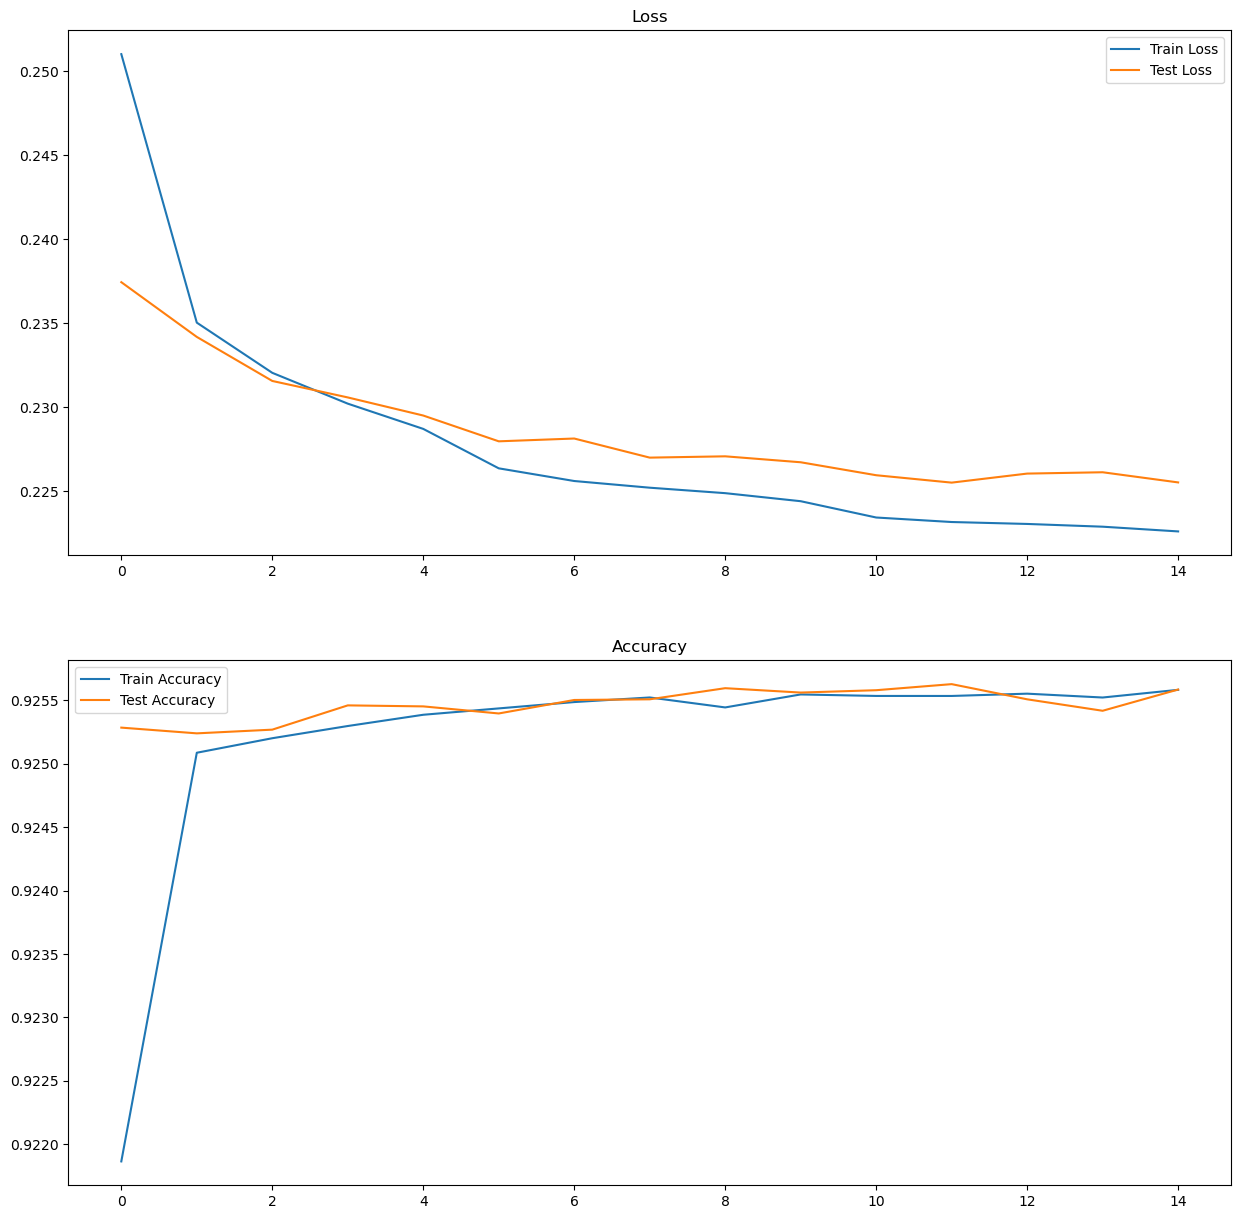

In [13]:
trainer.train()

In [14]:
torch.save(classification_transformer.state_dict(), "../Models/ClassificationTransformerS.pt")

# Inference

In [15]:
classification_transformer.eval()
with torch.inference_mode():
    x, y = dataset[torch.randint(0, len(dataset), [1]).item()]
    y_pred = classification_transformer(x.unsqueeze(0).to(device))
    print(torch.sigmoid(y_pred))
    print(y)

tensor([[1.1751e-02, 3.4807e-02, 1.1734e-02, 2.3688e-02, 3.6783e-02, 8.0684e-03,
         4.1184e-02, 2.0742e-03, 4.6831e-04, 1.6079e-02, 6.7228e-03, 8.6390e-03,
         2.3658e-02, 9.9700e-04, 8.4707e-01, 8.0517e-03, 6.8319e-04, 1.4058e-02,
         2.4504e-04, 2.4743e-04, 1.8609e-01, 6.5368e-02, 2.1820e-01, 9.8250e-02,
         1.4461e-01, 8.9446e-02, 2.7203e-02, 2.0844e-01]], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
